In [3]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt

In [47]:
def LLG(t, m, Beff, gammaLL, alpha):
    return -gammaLL * (np.cross(m, Beff) + alpha*np.cross(m, np.cross(m, Beff))) / (1 + alpha**2)

def LLG_tdep(t, m, f_Beff, gammaLL, alpha):
    Beff = f_Beff(t)
    return -gammaLL * (np.cross(m, Beff) + alpha*np.cross(m, np.cross(m, Beff))) / (1 + alpha**2)

def f_Beff_factory(Bext, w_cutoff, h):
    def inner(t):
        return np.array([h * np.sinc(w_cutoff * t / np.pi), 0, Bext])
    
    return inner

def fft_wrapper(time, timeseries, slice_=None):
    if slice_:
        time = time[slice_]
        timeseries = timeseries[slice_]
        
    ws = fftfreq(len(time), time[1] - time[0])
    amps = np.abs(fft(timeseries))
    
    return ws[:middle(ws)], amps[:middle(ws)]


def middle(seq):
    return len(seq) // 2

def free_photon_prop(w, wc):
    return 1 / (w - wc)

def photon_prop(w, wc, chi, lam):
    D0 = free_photon_prop(w, wc)
    return D0 - lam**2*D0*chi*D0

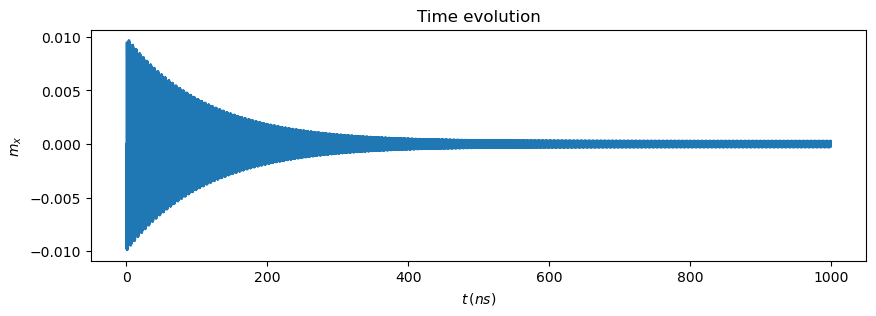

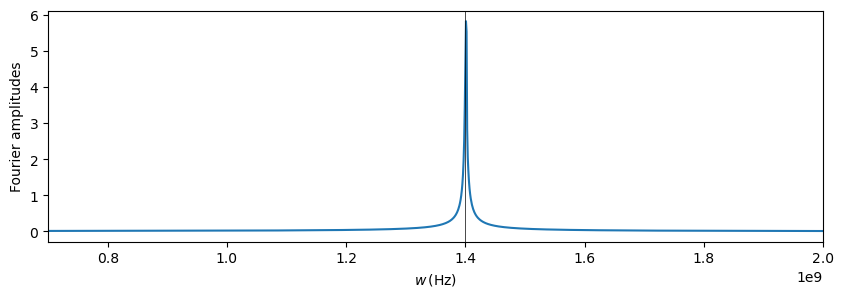

In [5]:
plt.rcParams['figure.figsize'] = (10, 3)

N = 100
tmax = 1000e-9
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, np.sqrt(1 - my0**2)])
gammaLL = 28e9 * 2*np.pi
wz = 1.4e9
Beff = np.array([0, 0, 2*np.pi*wz/gammaLL])
t_eval = np.linspace(0, tmax, 10000)
sol = solve_ivp(LLG, (0, tmax), m0, args=(Beff, gammaLL, alpha), t_eval=t_eval)
ws, amps = fft_wrapper(sol.t, sol.y[0])

plt.plot(sol.t * 1e9, sol.y[0])
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()
plt.plot(ws[:len(ws)//2], amps[:len(ws)//2])
plt.xlim(0.7e9, 2e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.axvline(1.4e9, c='k', lw=0.5)
plt.show()

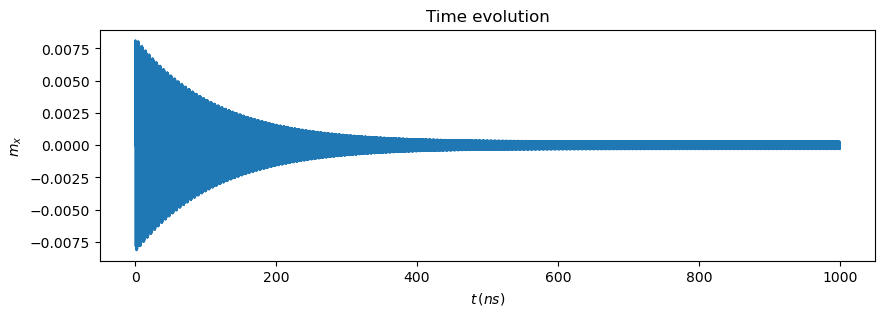

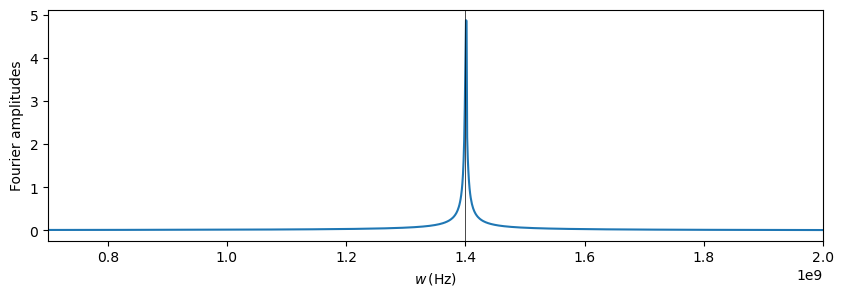

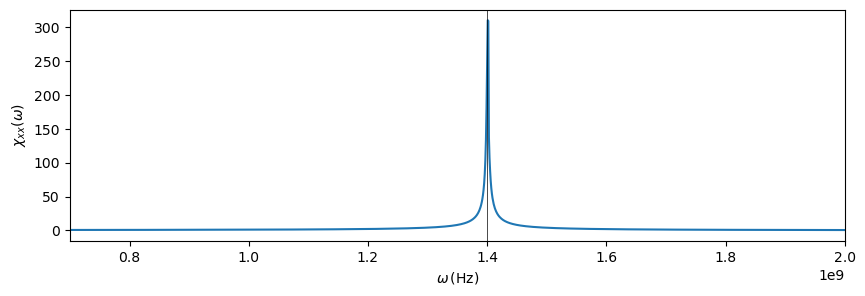

In [46]:
plt.rcParams['figure.figsize'] = (10, 3)

N = 10
tmax = 1000e-9
alpha = 1e-3
m0 = np.array([0, 0, 1])
gammaLL = 28e9 * 2*np.pi
wz = 1.4e9
w_cutoff = 2 * 2*np.pi*wz
Bext = 2*np.pi*wz/gammaLL
h = 0.01 * Bext
f_Beff = f_Beff_factory(Bext, w_cutoff, h)
t_eval = np.linspace(0, tmax, 10000)
sol = solve_ivp(LLG_tdep, (0, tmax), m0, args=(f_Beff, gammaLL, alpha), t_eval=t_eval)
ws, amps = fft_wrapper(sol.t, sol.y[0])

plt.plot(sol.t * 1e9, sol.y[0])
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()

plt.plot(ws, amps)
plt.xlim(0.7e9, 2e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.axvline(1.4e9, c='k', lw=0.5)
plt.show()

chi = amps * w_cutoff / (gammaLL * h * np.pi)
plt.plot(ws, chi)
plt.xlim(0.7e9, 2e9)
plt.ylabel(r'$\chi_{xx}(\omega)$')
plt.xlabel(r'$\omega \, ({\rm Hz})$')
plt.axvline(1.4e9, c='k', lw=0.5)
plt.show()

plt.plot(ws, photon_prop(ws, wc, chi, np.sqrt(N) * gammaLL * brms / (2 * hbar)))
plt.xlim(0.7e9, 2e9)
plt.ylabel(r'$\chi_{xx}(\omega)$')
plt.xlabel(r'$\omega \, ({\rm Hz})$')
plt.axvline(1.4e9, c='k', lw=0.5)
plt.show()

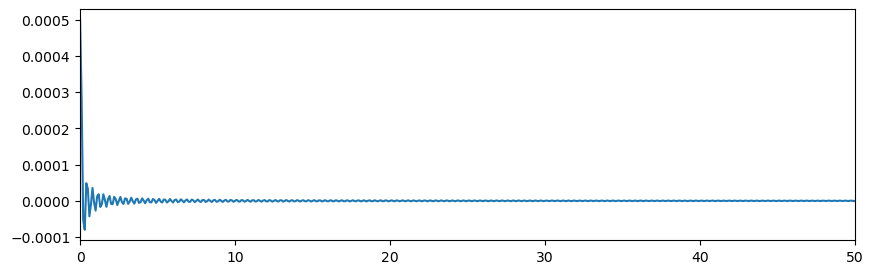

In [31]:
plt.plot(sol.t * 1e9, [f_Beff(t)[0] for t in sol.t])
plt.xlim(0, 50)
plt.show()